In [2]:
%pylab inline
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.image as mpimg
import os
import scipy.misc as sm
import skimage

Populating the interactive namespace from numpy and matplotlib


In [15]:
import cv2
import glob
import matplotlib.pyplot as plt

img_path = '/home/tanker/Downloads/canny_edge_detector-master/faces_imgs/'
img_paths = sorted(glob.glob(os.path.join(img_path,'*.jpg')))
bgr_images = []
gray_images = []
for img_path in img_paths:
    print(img_path)
    bgr_img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    gray_images.append(gray_img)
    bgr_images.append(bgr_img)

/home/tanker/Downloads/canny_edge_detector-master/faces_imgs/1.jpg
/home/tanker/Downloads/canny_edge_detector-master/faces_imgs/2.jpg
/home/tanker/Downloads/canny_edge_detector-master/faces_imgs/3.jpg
/home/tanker/Downloads/canny_edge_detector-master/faces_imgs/4.jpg
/home/tanker/Downloads/canny_edge_detector-master/faces_imgs/5.jpg
/home/tanker/Downloads/canny_edge_detector-master/faces_imgs/6.jpg


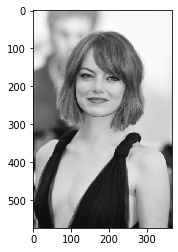

In [16]:
plt.imshow(gray_images[3],cmap='gray', vmin = 0, vmax = 255)

In [17]:
from scipy import ndimage

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)
    

def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    #pi_4 = np.pi / 4
    #pi_2 = np.pi / 2
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                #theta = D[i,j] #* 180 / np.pi #angle in degrees
                #theta_mod = theta % np.pi
                q = 255
                r = 255
                #alpha = None
                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
                

            except IndexError as e:
                pass
    
    return Z

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

def hysteresis(img, weak, strong=255):
    
    M, N = img.shape  
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    
    return img

In [110]:
from  skimage.feature import canny
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import convolve

from scipy import misc
import numpy as np


def Canny_detector(img):
    """ Your implementation instead of skimage """
    
    img_filtered = convolve(img, gaussian_kernel(5, sigma=12.4))
    grad, theta = sobel_filters(img_filtered)
    img_nms = non_max_suppression(grad, theta)
    img_thresh, weak, strong = threshold(img_nms, lowThresholdRatio=0.03, highThresholdRatio=0.9)
    img_final = hysteresis(img_thresh, weak, strong=strong)
   
    return img_final

In [111]:
canny_imgs = []
for i, img in enumerate(gray_images):
    print("Processing image %i" % (i+1))
    canny_img = Canny_detector(img)
    canny_imgs.append(canny_img)
    


Processing image 1
Processing image 2
Processing image 3
Processing image 4
Processing image 5
Processing image 6


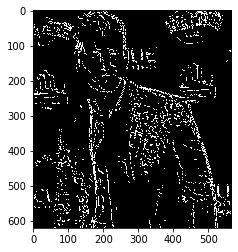

In [112]:

plt.imshow(canny_imgs[5],cmap='gray')


In [58]:
def mse(X, Y):
    xh, xw = X.shape
    yh, yw = Y.shape
    
  
    assert ((xw == yw) or (xh == yh)), \
    "Arguments dimensions are not equals: %s not equal to %s" % (str(xw), str(yw))
    a = [((X[i,j] - Y[i,j])**2) for i in range(xh) for j in range(xw)]
    return np.sum(a) / (xw * xh)

In [81]:
x  = mse(gray_images[5],canny_imgs[5])

In [82]:
x

29051.375391907502

In [62]:
canny_imgs[1]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 255, ..., 255, 255,   0],
       [  0,   0,   0, ...,   0, 255,   0],
       ...,
       [  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)